In [1]:
import requests
from bs4 import BeautifulSoup
import lxml
import os
import urllib
import sys
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import csv
import multiprocessing
import matplotlib.pyplot as plt

In [2]:
os.listdir('../input/iwildcam-2019-fgvc6')

['sample_submission.csv',
 'test_images',
 'train_images',
 'test.csv',
 'train.csv']

In [3]:
train=pd.read_csv("../input/iwildcam-2019-fgvc6/train.csv")
test=pd.read_csv("../input/iwildcam-2019-fgvc6/test.csv")
train.head()

,category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747
1,19,2012-03-17 03:48:44,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,2,588a679f-23d2-11e8-a6a3-ec086b02610b,115,Justin Brown,6f12067d-5567-11e8-b3c0-dca9047ef277,3,1024,747
2,0,2014-05-11 11:56:46,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,1,59279ce3-23d2-11e8-a6a3-ec086b02610b,96,Erin Boydston,6faa92d1-5567-11e8-b1ae-dca9047ef277,1,1024,747
3,0,2013-10-06 02:00:00,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,1,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,57,Erin Boydston,6f7d4702-5567-11e8-9e03-dca9047ef277,1,1024,747
4,0,2011-07-12 13:11:16,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg,3,599fbd89-23d2-11e8-a6a3-ec086b02610b,46,Justin Brown,6f1728a1-5567-11e8-9be7-dca9047ef277,3,1024,747


In [4]:
len(os.listdir('../input/iwildcam-2019-fgvc6/train_images'))

196086

In [5]:
len(train.id)

196299

In [6]:
img=[]
filename=train.id[:10000]
label=train.category_id[:10000]
for file in filename:
    image=cv2.imread("../input/iwildcam-2019-fgvc6/train_images/"+file+'.jpg')
    res=cv2.resize(image,(32,32))
    img.append(res)
img=np.array(img)

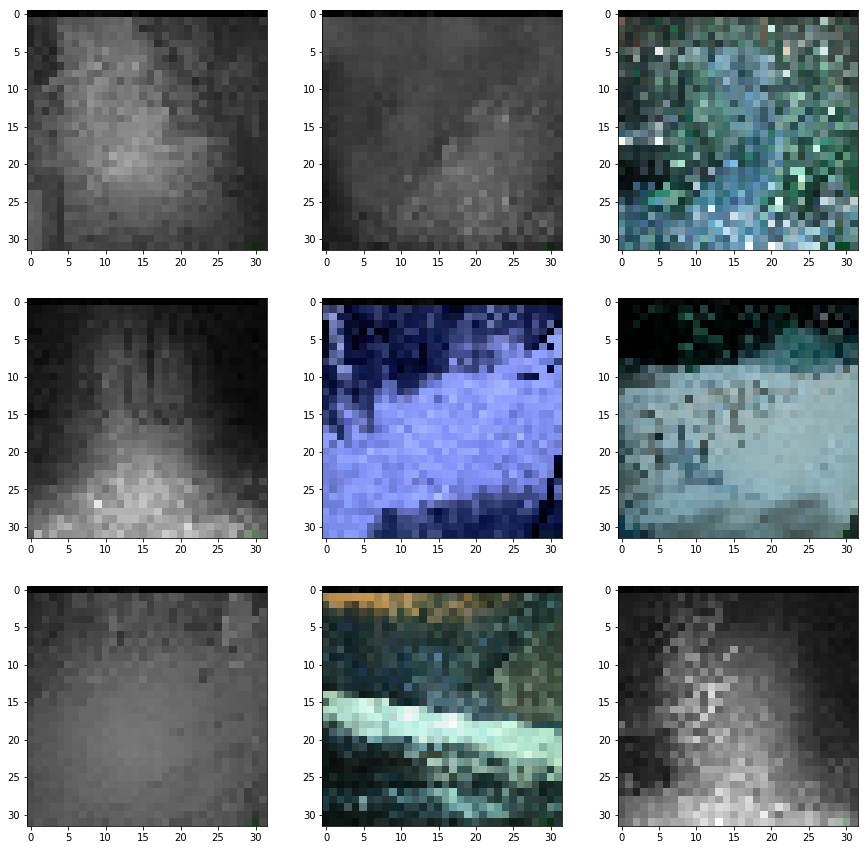

In [7]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(img[i])

In [8]:
np.random.seed(921)
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
X_train,X_test,y_train,y_test=train_test_split(img,label,test_size=0.2)
del img
y_train=y_train.astype(int)
y_test=y_test.astype(int)
y_train=np.array(y_train).reshape(-1,1)
y_test=np.array(y_test).reshape(-1,1)
X_train=X_train.reshape(-1,32,32,3)/255 #Normalize
X_test=X_test.reshape(-1,32,32,3)/255
y_train=np_utils.to_categorical(y_train,num_classes=max(label)+1)
y_test=np_utils.to_categorical(y_test,num_classes=max(label)+1)

Using TensorFlow backend.


Train on 6400 samples, validate on 1600 samples
Epoch 1/20
6400/6400 [==============================] - 17s 3ms/step - loss: 1.5533 - acc: 0.6422 - val_loss: 1.4717 - val_acc: 0.6644
Epoch 2/20
6400/6400 [==============================] - 15s 2ms/step - loss: 0.9929 - acc: 0.7098 - val_loss: 1.7448 - val_acc: 0.6719
Epoch 3/20
6400/6400 [==============================] - 16s 2ms/step - loss: 0.8777 - acc: 0.7325 - val_loss: 1.5756 - val_acc: 0.7306
Epoch 4/20
6400/6400 [==============================] - 16s 2ms/step - loss: 0.8154 - acc: 0.7450 - val_loss: 1.7188 - val_acc: 0.7500
Epoch 5/20
6400/6400 [==============================] - 16s 2ms/step - loss: 0.7603 - acc: 0.7653 - val_loss: 1.6460 - val_acc: 0.7600
Epoch 6/20
6400/6400 [==============================] - 16s 2ms/step - loss: 0.7256 - acc: 0.7695 - val_loss: 1.4116 - val_acc: 0.7381
Epoch 7/20
6400/6400 [==============================] - 16s 2ms/step - loss: 0.7035 - acc: 0.7761 - val_loss: 1.3713 - val_acc: 0.7506
Epoch 8

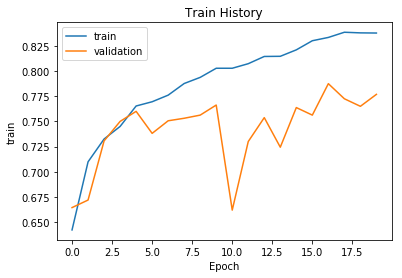

In [9]:
model=Sequential()
model.add(Convolution2D(filters=32,kernel_size=(3,3),input_shape=(32,32,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.35))

model.add(MaxPool2D(pool_size=(2,2),padding='same'))

model.add(Convolution2D(filters=64,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.45))

model.add(MaxPool2D(pool_size=(2,2),padding='same'))

model.add(Flatten())

model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.75))

model.add(Dense(max(label)+1,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

train_history=model.fit(X_train,y_train,validation_split=0.2,epochs=20,batch_size=128,verbose=1)
accuracy=model.evaluate(X_test,y_test,verbose=1)
print("test accuracy:",accuracy[1])#accuracy for test set



def show_train_history(train_history,train,validation):
	plt.plot(train_history.history[train])
	plt.plot(train_history.history[validation])
	plt.title('Train History')
	plt.ylabel('train')
	plt.xlabel('Epoch')
	plt.legend(['train','validation'],loc='upper left')
	plt.show()

show_train_history(train_history,'acc','val_acc') #acc:accuracy for training set. val_acc:accuracy for validation.

In [10]:
prediction=model.predict_classes(X_test)
print(prediction[0:10])

[ 8  0 19 19  0  0  0  0  0  0]


In [11]:
img_test=[]
filename_test=test.id[:10000]
for file in filename_test:
    image=cv2.imread("../input/iwildcam-2019-fgvc6/test_images/"+file+'.jpg')
    res=cv2.resize(image,(32,32))
    img_test.append(res)
img_test=np.array(img_test)

In [12]:
prediction=model.predict_classes(img_test)
print(prediction[0:10])

[0 0 0 0 0 0 0 0 0 0]


In [13]:
submit=pd.DataFrame({'Id':filename_test,'Predicted':prediction})
submit.to_csv('submission.csv',index=False)